## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

# Import Library

In [95]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [96]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 10

# Prepare Training Data
1. Descárgate el dataset
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador.
3. En este punto vamos guardar en una lista las etiquetas de cada foto.

In [97]:
import os

ROOT_PATH = os.getcwd()
TRAIN_PATH = ROOT_PATH + "/data/train/"
TEST_PATH = ROOT_PATH + "/data/test/"

In [98]:
TRAIN_PATH

'/Users/ivanlamb/Documents/GitHub/Machine_Learning/4-Deep_Learning/2-Redes_Convolucionales/data/train/'

In [99]:
##### CODE #####

# Listar todos los archivos de la carpeta de train (TRAIN_PATH)
filenames = os.listdir(TRAIN_PATH)

# Lista vacia
categories = []

# Iterar
for filename in filenames:
    # Saco el nombre
    category = filename.split('.')[0]
    
    # If else
    # Guardo en lista
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
}) 

### See Total In count

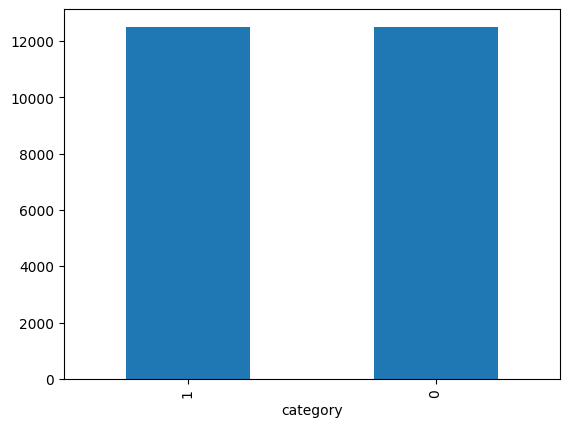

In [100]:
df['category'].value_counts().plot.bar();

# See sample image

(288, 221, 3)
255


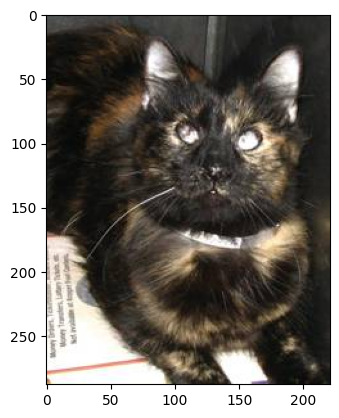

In [101]:
from skimage.io import imread
import cv2

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

print(image.shape)
print(np.max(image))
plt.imshow(image);

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [102]:
image

array([[[ 76,  80,  81],
        [ 79,  83,  84],
        [ 81,  85,  86],
        ...,
        [ 47,  47,  45],
        [ 48,  48,  46],
        [ 48,  48,  46]],

       [[ 74,  78,  79],
        [ 76,  80,  81],
        [ 78,  82,  83],
        ...,
        [ 51,  51,  49],
        [ 51,  51,  49],
        [ 51,  51,  49]],

       [[ 78,  82,  81],
        [ 80,  84,  83],
        [ 81,  85,  84],
        ...,
        [ 50,  50,  48],
        [ 51,  51,  49],
        [ 51,  51,  49]],

       ...,

       [[167, 112,  92],
        [162, 111,  92],
        [201, 153, 139],
        ...,
        [ 24,  26,  21],
        [ 21,  23,  22],
        [ 19,  23,  24]],

       [[182, 141,  97],
        [179, 140,  97],
        [190, 156, 118],
        ...,
        [ 32,  37,  31],
        [ 25,  29,  28],
        [ 19,  23,  26]],

       [[180, 145,  89],
        [196, 165, 110],
        [201, 173, 125],
        ...,
        [ 40,  45,  39],
        [ 30,  34,  33],
        [ 20,  24,  27]]

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

Tamaño imagen original: (374, 500, 3)
Tamaño imagen reshape: (32, 32, 3)


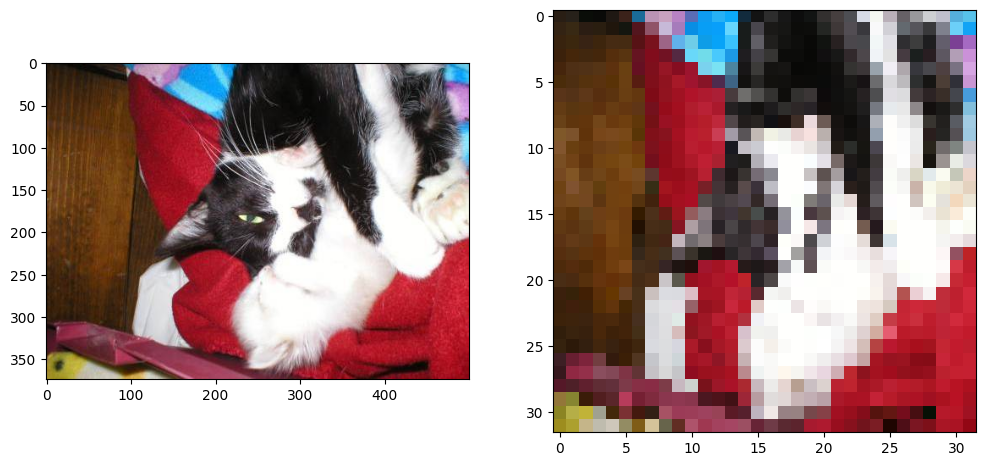

In [103]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

Tamaño imagen original: (375, 499)


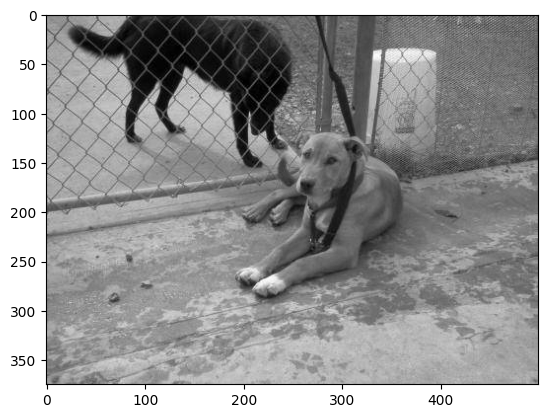

In [104]:
sample = random.choice(filenames)

image = cv2.imread(filename = TRAIN_PATH + sample, flags = cv2.IMREAD_GRAYSCALE)

print("Tamaño imagen original:", image.shape)
plt.imshow(image, cmap='gray');

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [105]:
def read_data(path, im_size):
    X = []
    Y = []

    ##### CODE #####
    # Iterar sobre todo lo que haya en path
    for file in os.listdir(path):
        
        # Leer la imagen a color y aplicarle el resize
        image = imread(path + file)
        smallimage = cv2.resize(image, (im_size, im_size))
        
        # Guardo en X
        X.append(smallimage)
        
        category = file.split('.')[0]
        # Miro si es perro y gato para guardar en Y
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)
        

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_WIDTH)
X_test, y_test = read_data(TEST_PATH, IMAGE_WIDTH)

print(X_train.shape)
print(X_test.shape)

(25000, 32, 32, 3)
(3456, 32, 32, 3)


(32, 32, 3)


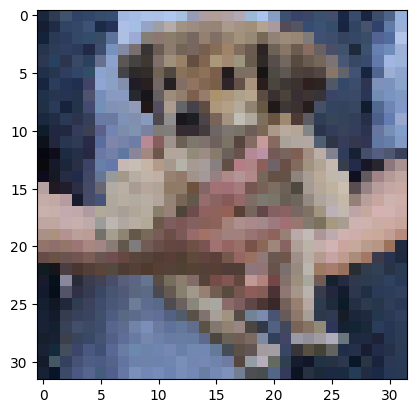

In [106]:
print(X_train[0].shape)
plt.imshow(X_train[0]);

In [107]:
X_train[0]

array([[[ 24,  39,  60],
        [ 46,  59,  83],
        [ 65,  82, 111],
        ...,
        [ 60,  77, 108],
        [ 77,  99, 135],
        [149, 177, 219]],

       [[ 23,  30,  50],
        [ 32,  44,  70],
        [ 49,  68, 101],
        ...,
        [ 48,  65, 107],
        [ 96, 123, 168],
        [155, 176, 215]],

       [[ 20,  34,  60],
        [ 41,  58,  84],
        [ 44,  60,  93],
        ...,
        [ 82,  99, 148],
        [ 82, 108, 157],
        [178, 197, 231]],

       ...,

       [[ 25,  34,  53],
        [ 19,  42,  58],
        [ 68,  77,  90],
        ...,
        [ 34,  44,  73],
        [ 37,  49,  73],
        [ 43,  59,  85]],

       [[ 20,  28,  44],
        [ 69,  87,  98],
        [ 51,  65,  95],
        ...,
        [ 25,  35,  60],
        [ 44,  55,  83],
        [ 41,  58,  84]],

       [[ 23,  32,  52],
        [  9,  21,  38],
        [ 58,  74, 103],
        ...,
        [ 25,  41,  70],
        [ 38,  56,  85],
        [ 41,  57,  83]]

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [108]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [109]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


# Shuffle data
Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [110]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [111]:
X_train

array([[[[0.36862745, 0.45098039, 0.37647059],
         [0.36470588, 0.44705882, 0.38823529],
         [0.36470588, 0.44705882, 0.38039216],
         ...,
         [0.48627451, 0.50588235, 0.42745098],
         [0.48627451, 0.50588235, 0.42745098],
         [0.48627451, 0.50588235, 0.42745098]],

        [[0.36862745, 0.45098039, 0.37254902],
         [0.37254902, 0.45098039, 0.37647059],
         [0.38431373, 0.45098039, 0.38039216],
         ...,
         [0.49411765, 0.50980392, 0.44313725],
         [0.49019608, 0.50588235, 0.44705882],
         [0.48235294, 0.52941176, 0.43529412]],

        [[0.36862745, 0.45098039, 0.37647059],
         [0.35686275, 0.43921569, 0.36470588],
         [0.38039216, 0.44313725, 0.37254902],
         ...,
         [0.49803922, 0.50980392, 0.42745098],
         [0.50588235, 0.51764706, 0.43529412],
         [0.49019608, 0.50980392, 0.42352941]],

        ...,

        [[0.41960784, 0.43137255, 0.30980392],
         [0.36078431, 0.36862745, 0.25882353]

# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [112]:
np.savez(ROOT_PATH + '/data.npz',
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test)

Para cargar

In [113]:
data = np.load(ROOT_PATH + '/data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']


# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario. O 

In [114]:
from tensorflow import keras

layers = [
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
]

model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [115]:
64*(3*3)*3+ 64

1792

In [116]:
128*(3*3)*3

3456

In [117]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

# Callbacks
#### Early Stopping

In [118]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

In [119]:
from keras.callbacks import ModelCheckpoint
mcheckpoint = ModelCheckpoint("callback_model.h5")

# Fit the model

In [120]:
history = model.fit(X_train,
         y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2,
         verbose=0)

/opt/homebrew/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluate
Probemos los datos en el conjunto de test.

In [121]:
results = model.evaluate(X_test, y_test)
results

108/108 [==============================] - 1s 7ms/step - loss: 0.2137 - accuracy: 0.9196


[0.21368099749088287, 0.9195601940155029]

In [122]:
model.predict(X_test).round(0)

108/108 [==============================] - 1s 7ms/step


array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [123]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, model.predict(X_test).round(0))

108/108 [==============================] - 1s 8ms/step


array([[1559,   89],
       [ 189, 1619]])

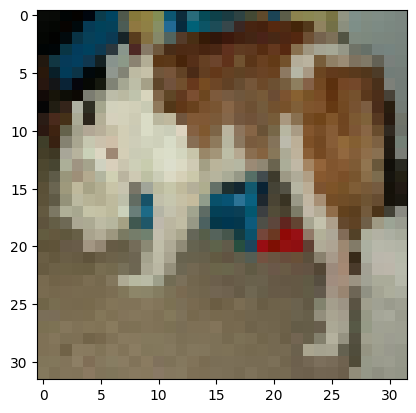

In [124]:
plt.imshow(X_test[-1]);

In [125]:
predictions = model.predict(X_test[-1:]).round(0)
predictions

1/1 [==============================] - 0s 114ms/step


array([[1.]], dtype=float32)

# Image data generator

In [127]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

Categorias: ['dog' 'cat']


,filename,category
0,dog.8011.jpg,dog
1,cat.5077.jpg,cat
2,dog.7322.jpg,dog
3,cat.2718.jpg,cat
4,cat.10151.jpg,cat


In [129]:
from keras.preprocessing.image import ImageDataGenerator, load_img

example_df = df.sample(n=1).reset_index(drop=True)
example_df

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    TRAIN_PATH,
    x_col = 'filename',
    y_col = 'category',
    target_size = (128, 128)
)

Found 1 validated image filenames belonging to 1 classes.


In [130]:
np.unique(y_train)

array([0, 1])

In [131]:
example_df

,filename,category
0,dog.11341.jpg,dog


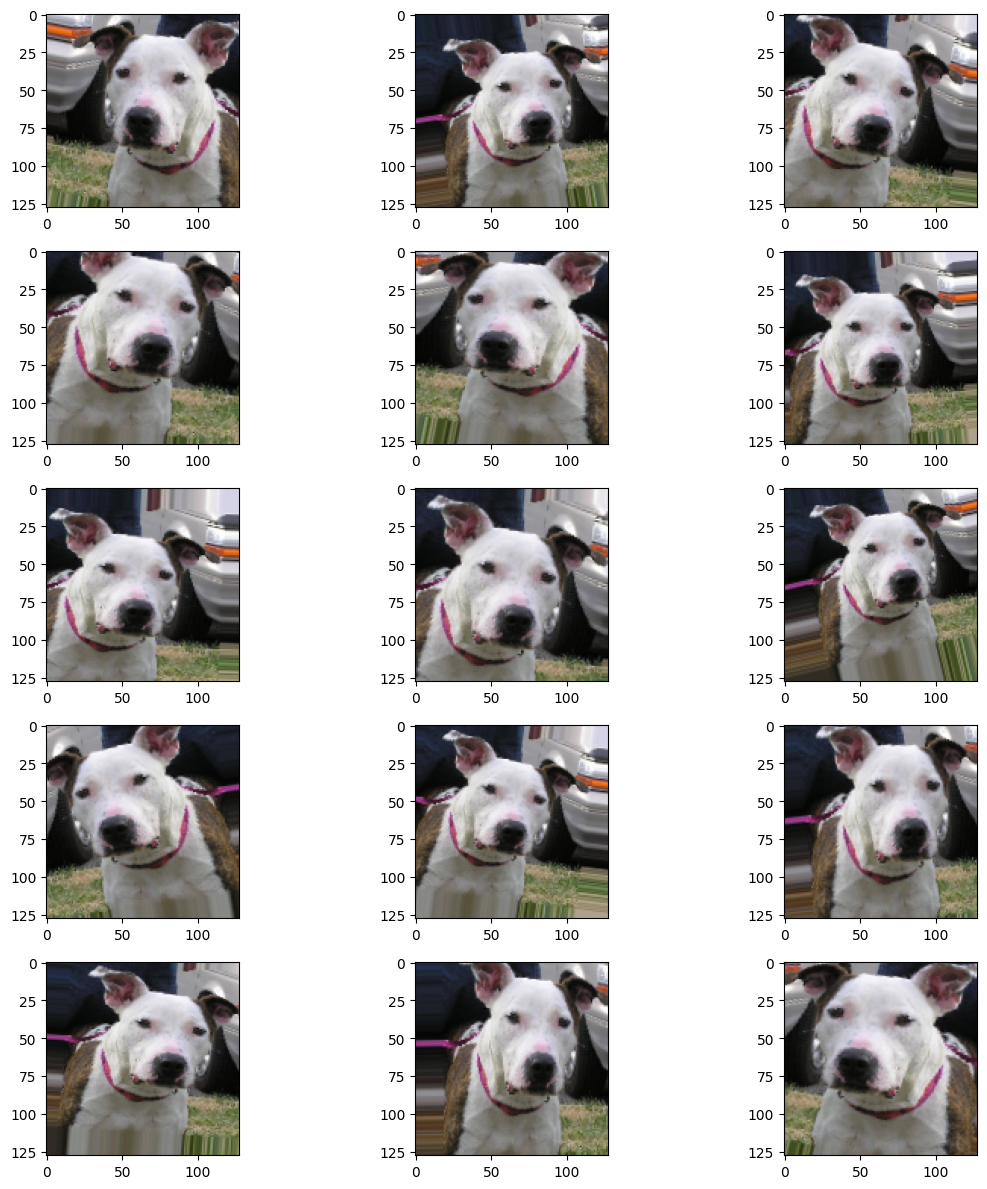

In [132]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Training Generator

In [133]:
train_df, validate_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [134]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 20000
Shape validation 5000


,filename,category
0,cat.1474.jpg,cat
1,dog.11287.jpg,dog
2,dog.8276.jpg,dog
3,cat.7227.jpg,cat
4,cat.2997.jpg,cat


In [135]:
train_df.head()

,filename,category
0,cat.11282.jpg,cat
1,cat.7693.jpg,cat
2,cat.4977.jpg,cat
3,dog.9403.jpg,dog
4,cat.10150.jpg,cat


In [136]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [137]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


# Fit Model

In [138]:
model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [139]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data = validation_generator
)

Epoch 1/10
625/625 [==============================] - 44s 70ms/step - loss: 0.4765 - accuracy: 0.7719 - val_loss: 0.3516 - val_accuracy: 0.8436
Epoch 2/10
625/625 [==============================] - 40s 65ms/step - loss: 0.4556 - accuracy: 0.7834 - val_loss: 0.4014 - val_accuracy: 0.8034
Epoch 3/10
625/625 [==============================] - 40s 64ms/step - loss: 0.4469 - accuracy: 0.7883 - val_loss: 0.3347 - val_accuracy: 0.8546
Epoch 4/10
625/625 [==============================] - 40s 63ms/step - loss: 0.4356 - accuracy: 0.7951 - val_loss: 0.3866 - val_accuracy: 0.8168
Epoch 5/10
625/625 [==============================] - 40s 63ms/step - loss: 0.4303 - accuracy: 0.7950 - val_loss: 0.3799 - val_accuracy: 0.8178
Epoch 6/10
625/625 [==============================] - 41s 65ms/step - loss: 0.4268 - accuracy: 0.7985 - val_loss: 0.3296 - val_accuracy: 0.8538
Epoch 7/10
625/625 [==============================] - 42s 67ms/step - loss: 0.4196 - accuracy: 0.8054 - val_loss: 0.3866 - val_accuracy:

In [140]:
##### CODE #####

# Listar todos los archivos de la carpeta de train (TEST_PATH)
filenames = os.listdir(TEST_PATH)

# Lista vacia
categories = []

# Iterar
for filename in filenames:
    # Saco el nombre
    category = filename.split('.')[0]
    
    # If else
    # Guardo en lista
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')
    
    
test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
}) 

In [141]:
test_df

,filename,category
0,cat.12020.jpg,cat
1,dog.9469.jpg,dog
2,cat.11529.jpg,cat
3,dog.8777.jpg,dog
4,dog.8763.jpg,dog
...,...,...
3451,dog.9470.jpg,dog
3452,cat.11530.jpg,cat
3453,cat.12039.jpg,cat
3454,cat.11256.jpg,cat


In [142]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    TEST_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 3456 validated image filenames belonging to 2 classes.


In [143]:
len(test_generator)

108

In [144]:
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

108/108 [==============================] - 5s 44ms/step - loss: 0.3473 - accuracy: 0.8371
test loss, test acc: [0.3472647964954376, 0.8370949029922485]


In [145]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

108/108 [==============================] - 1s 7ms/step - loss: 0.3356 - accuracy: 0.8449
test loss, test acc: [0.335627943277359, 0.8449074029922485]


# Virtualize Training

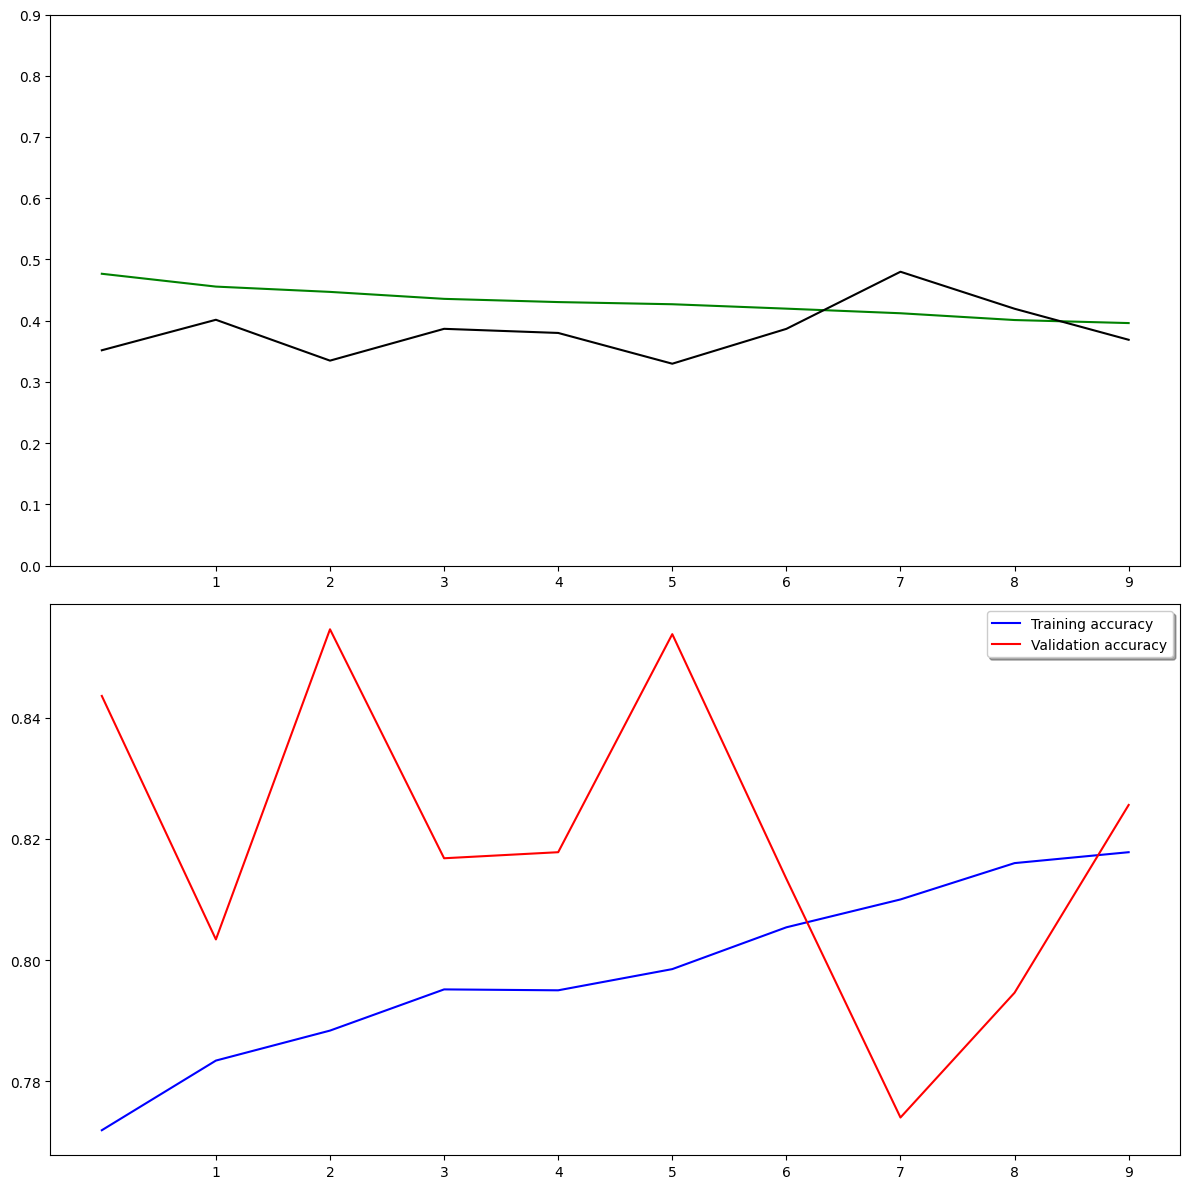

In [150]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='g', label="Training loss")
ax1.plot(history.history['val_loss'], color='k', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()